In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys,os
sys.path.insert(0, '/home/noah/Desktop/large_analysis/ca_analysis')
import fileread as fr
from scipy.signal import fftconvolve
import predefined as pd
import wave_ops as wo
from scipy import signal
from scipy.optimize import curve_fit
import matplotlib as mpl
import time

def background(t,*pars):
    a,b,offset,omega=pars
    return a*np.sin(omega*t)+b*np.cos(omega*t)+offset*np.ones(len(t))

def gauss(t,*pars):
    a,mu,sigma=pars
    return a*np.exp(-np.power((t.astype(float)-mu),2.)/(2.*sigma**2.))

means=np.array([1000, 1031.3367, 1086.8575, 1217.0291, 1041.5563, 1000, 1230.2096, 1188.8999,\
                1000, 1263.1642, 1233.1743, 1056.3289, 1213.4717, 1112.0769, 1049.4534, 1219.0482,\
                1000, 1000, 1077.4932, 1157.1627, 1000, 1163.2235, 1000, 1000,\
                1000, 1027.103, 1111.1212, 1033.5468, 1109.469, 1022.693, 1929.7336, 1000,\
                1000, 1124.478, 1073.1306, 1040.2197, 1100.4457, 1045.0566, 1135.8975, 1073.1854,\
                1000, 1000, 1087.187, 1133.1069, 1005.3494, 1000, 1000, 1000])

run='/home/noah/Desktop/large_analysis/ca_analysis/Run_131_0.bin';name=run[-13:-6]
#run='/home/noah/Desktop/large_analysis/ca_analysis/oscillation/Run_0_0.bin';name=run[-11:-6];means=np.ones(48,dtype='float')*1250


In [15]:
numwaves=int((os.stat(run).st_size-8)/7033)
#numwaves=20000
row=0
data=fr.raw(run,length=3500,row=row,numwaves=numwaves-row)
numwaves=len(data)

wo.baseline_restore(data,600)
length=3500

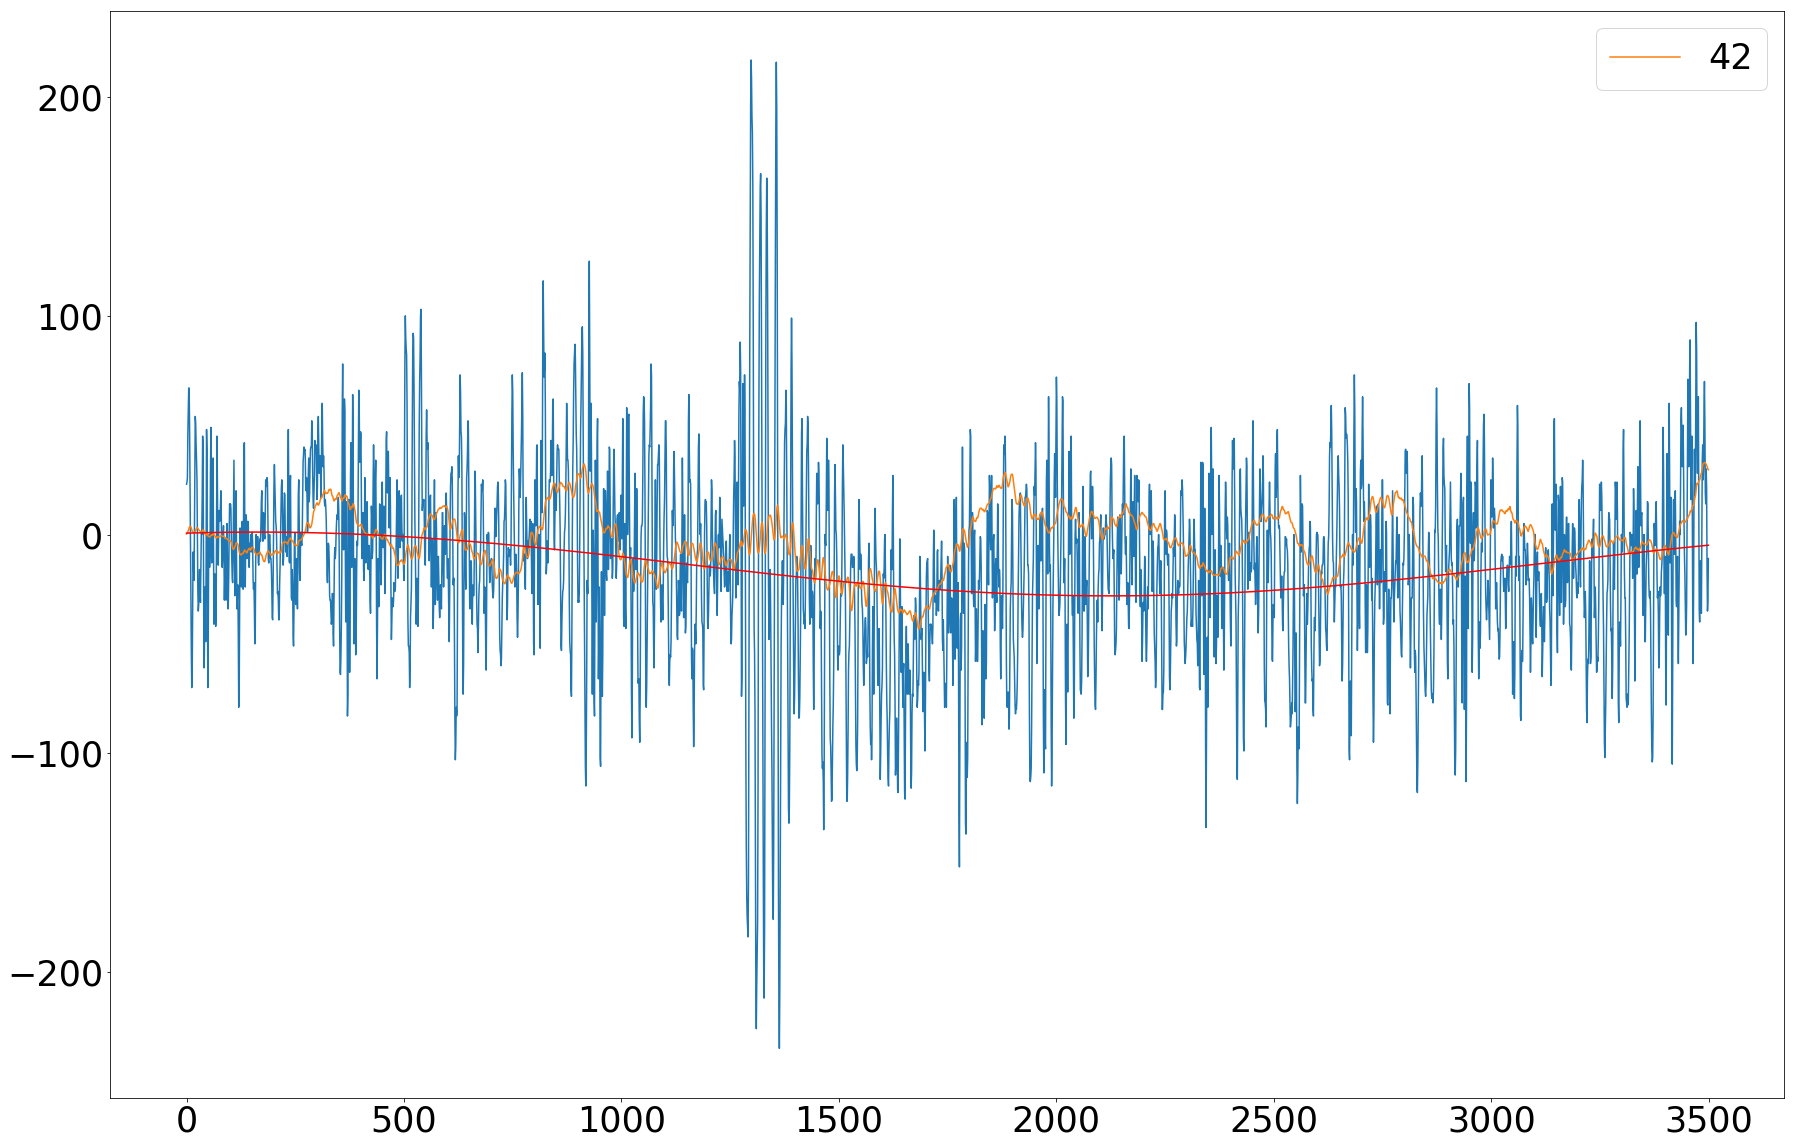

0.9181554317474365


In [19]:
t=np.arange(length); out=np.zeros(length); trap=np.zeros(length)
fall=0
plot=True
maxouts=0
omega=2*np.pi/length
pars=[]
beg=time.time()
for i in range(numwaves):
    try:
        bd,ch=data['board'][i],data['channel'][i]
        fall=means[data['board'][i]*8+data['channel'][i]]
        wo.trap(arr=trap,rise=100,top=70,fall=fall)
        out=signal.convolve(trap,data['wave'][i])[0:length]/(100*fall)
        maxout=np.amax(out)
        if maxout<50:
            p,v=curve_fit(background,t,data['wave'][i],p0=[maxout,maxout,0,omega],\
                               bounds=([-100,-100,-300,8E-4],[100,100,300,8E-3]))
            chisq=np.sum(np.power(background(t,*p)-data['wave'][i],2.))/(length-p.shape[0])
            pars.append(np.concatenate((p,np.sqrt(np.diag(v)),[chisq,bd,ch,i])));
            if i ==4 and plot==True:
                plt.figure(figsize=(30,20))
                plt.plot(t,data['wave'][i])
                plt.plot(t,out,label='{:0.0f}'.format(np.sqrt(chisq)))
                plt.plot(t,background(t,*p),'r-')
                plt.tick_params(labelsize=35)
                plt.legend(fontsize=35)
                plt.show()
                break
    except RuntimeError:
        continue
#        plt.figure(figsize=(30,20))
#        plt.plot(t,data['wave'][i])
#        plt.plot(t,out,label='{0:0.0f} | {1:s}'.format(np.amax(out),pd.pixel(bd,ch)))
        #plt.plot(t,background(t,*p),'r-')
#        plt.tick_params(labelsize=35)
#        plt.legend(fontsize=35)
#        plt.show()
pars=np.array(pars)
end=time.time()
print(end-beg)


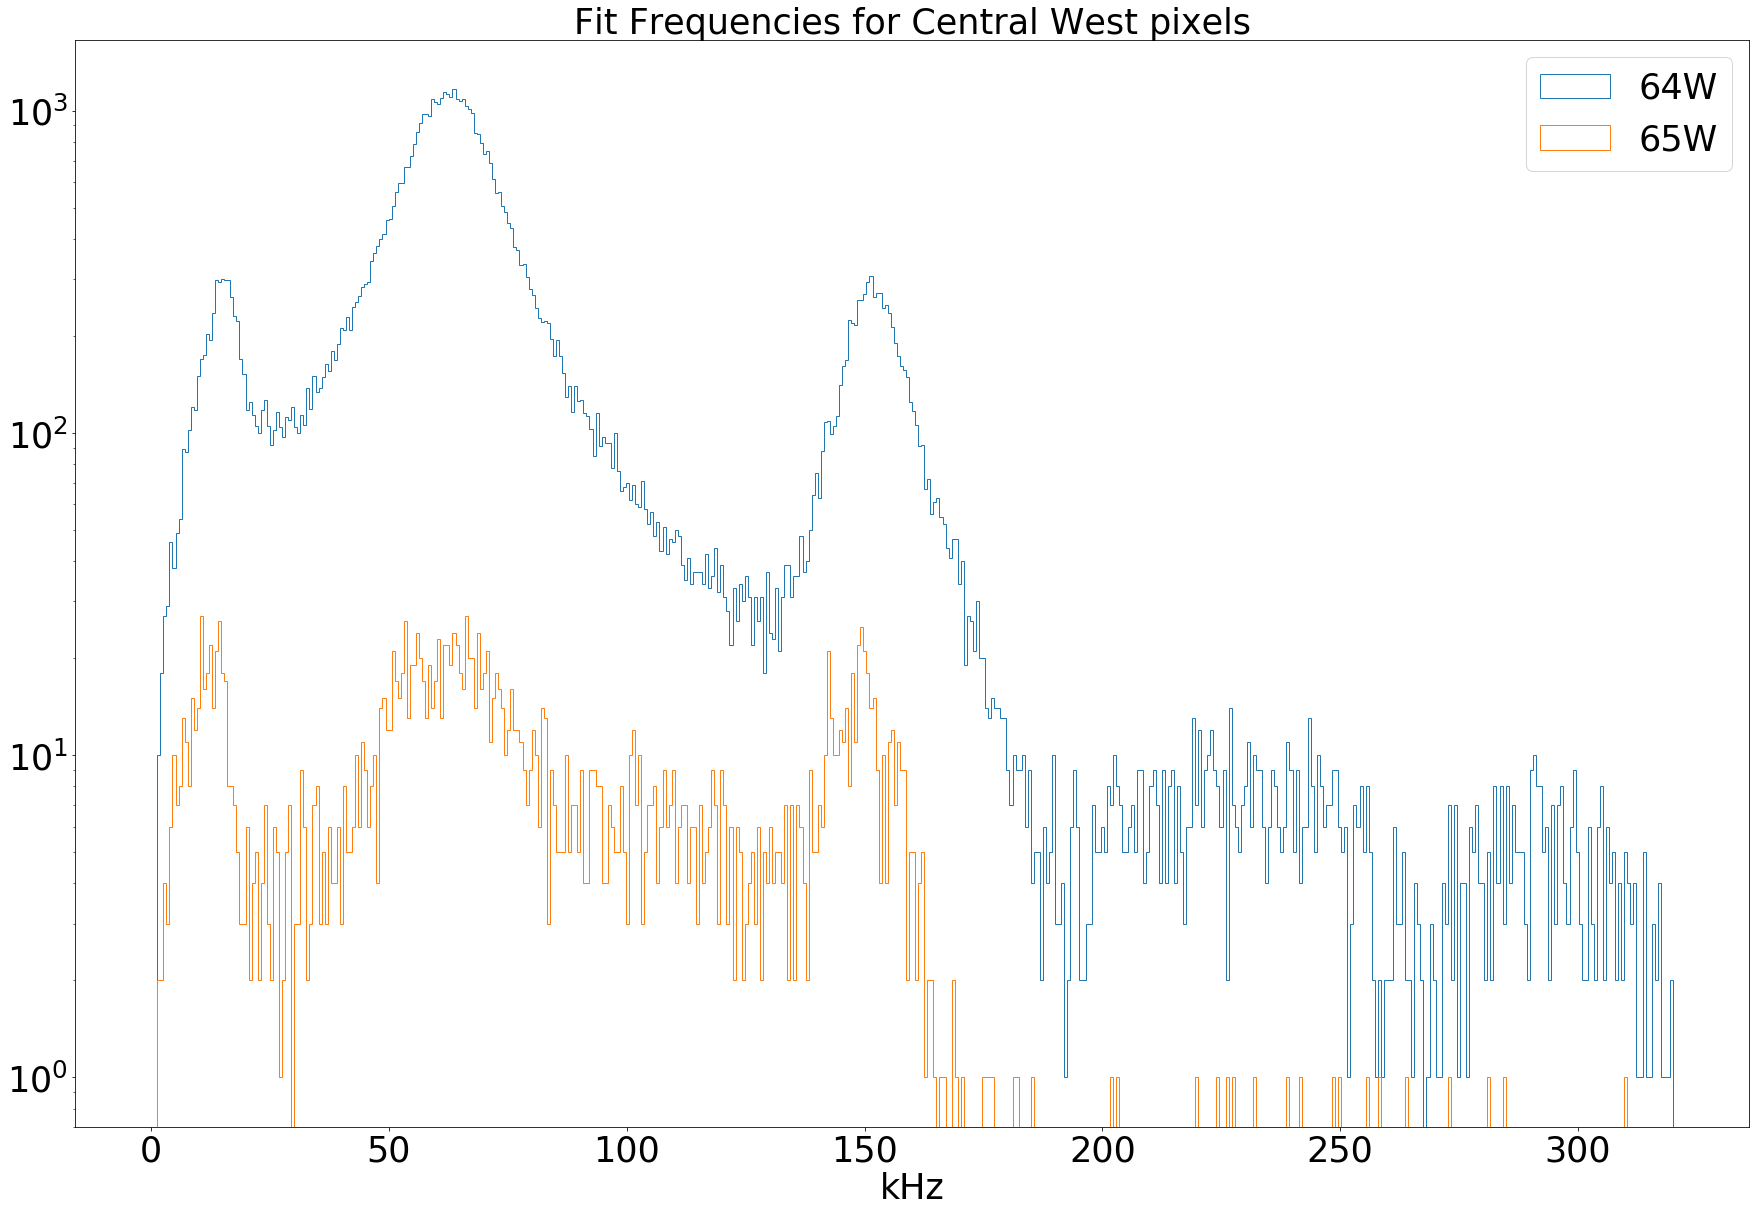

In [4]:
fs=35
bd,ch=3,3
savearray=False
loadarray=True
if savearray==True:
    np.save('True-Fit-pars.npy',pars)
if loadarray==True and savearray==False:
    pars=np.load('/home/noah/Desktop/large_analysis/ca_analysis/oscillation/'+\
                 'True_fit_pars/True-Fit-pars_Run_120-full.npy')

plt.figure(figsize=(30,20))

#for bd in np.arange(0,3,dtype=int):
for bd in np.arange(0,3,dtype=int):
    if bd == 3 or bd == 0:
        chs=np.arange(5,7,dtype=int)
    if bd == 4 or bd ==1:
        chs=np.concatenate((np.arange(2,5,dtype=int),np.array([7])))
    if bd == 5 or bd == 2:
        chs=np.arange(1,2,dtype=int)
    for ch in chs:
        trutharray=np.logical_and(pars[:,-3]==bd,pars[:,-2]==ch)
        if ch == 3 or ch ==4:
            plt.hist(pars[:,3][trutharray]/(2*np.pi*4E-9)/1000,\
                     bins=500,range=[0,320],histtype='step',label=pd.pixel(bd,ch))
plt.xlabel('kHz',fontsize=fs)
plt.yscale('log')
#plt.hist(pars[trutharray][:,4],bins=1000,range=[-100,100],histtype='step')
#plt.hist(pars[:,-2]*8+pars[:,-1],bins=48,range=[0,47])
plt.xlim()
plt.legend(fontsize=fs)
plt.tick_params(labelsize=fs)
if bd==2:
    plt.title('Fit Frequencies for Central West pixels',fontsize=fs)
    plt.savefig('west_central_frequencies')
else:
    plt.title('Fit Frequencies for Central East pixels',fontsize=fs)
    plt.savefig('east_central_frequencies')
plt.show()

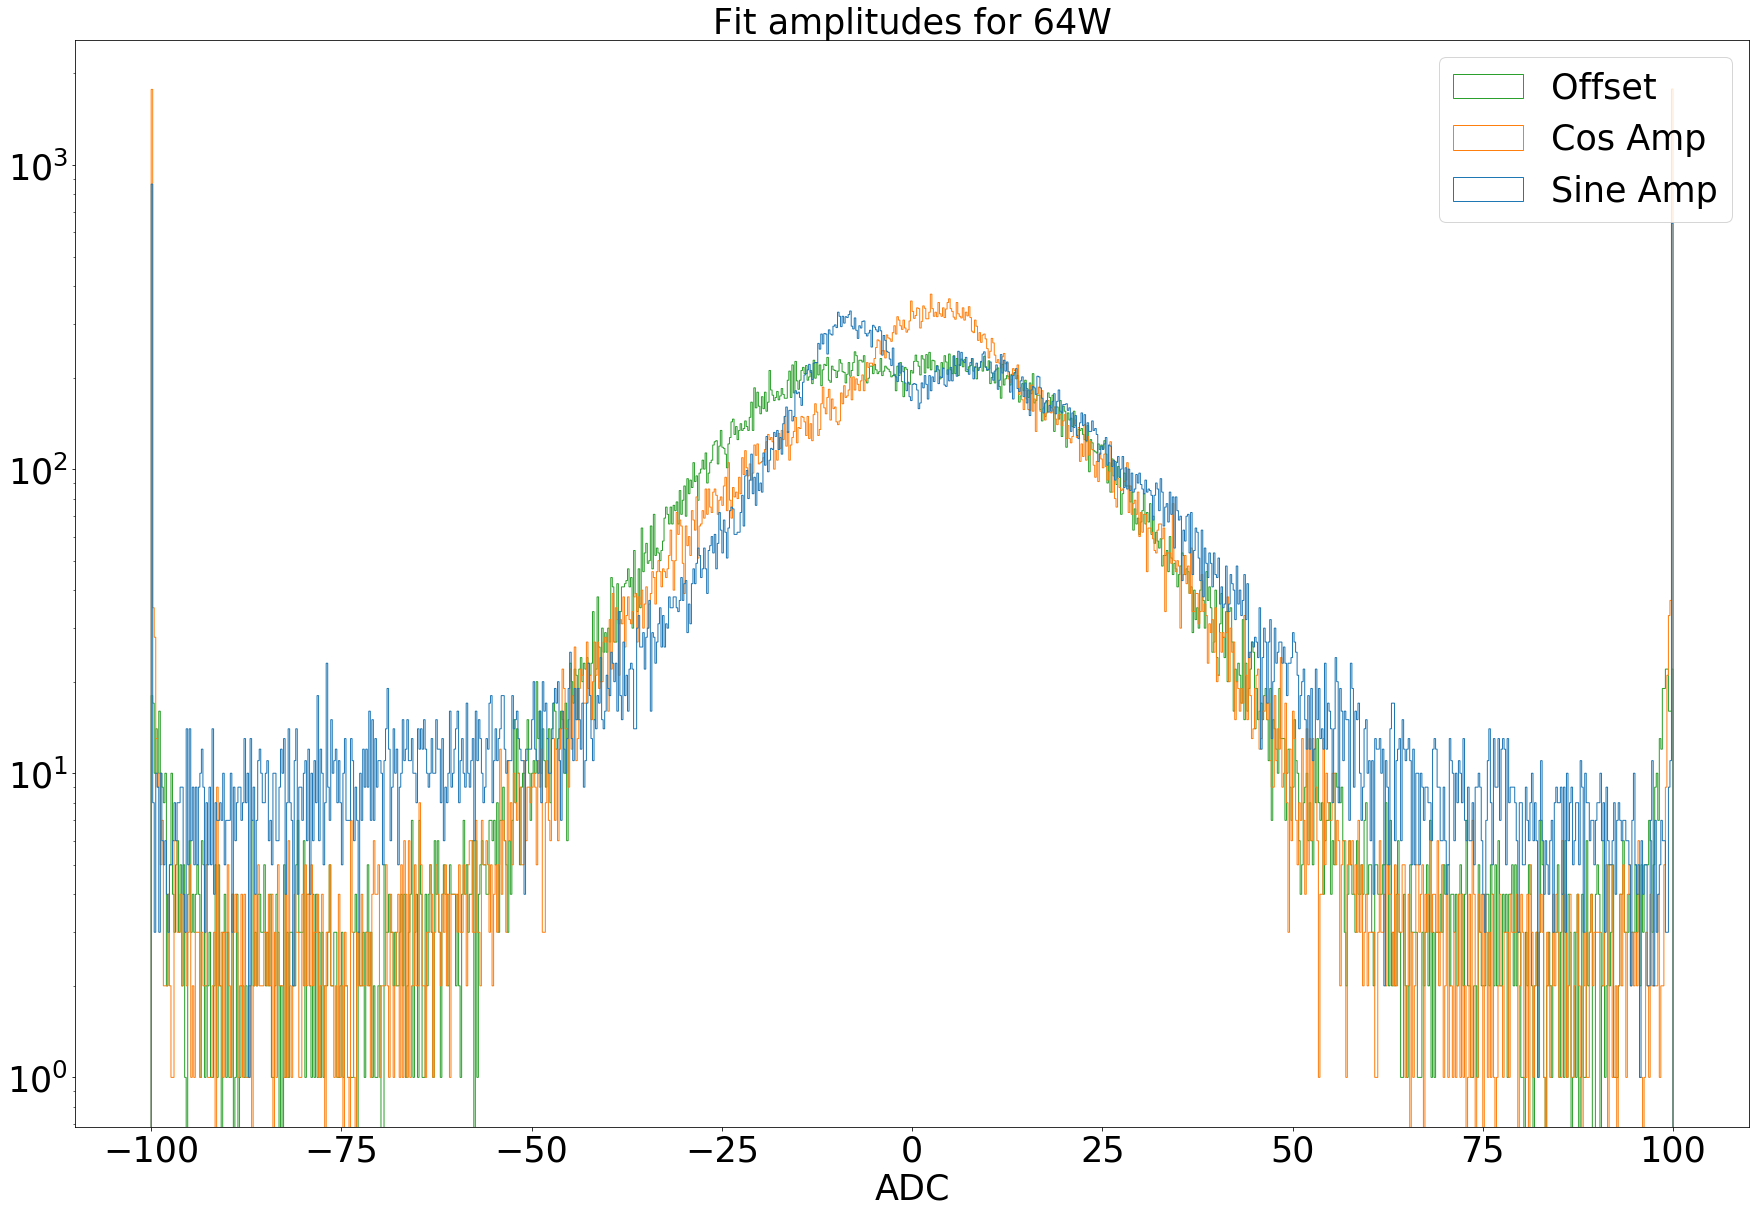

In [7]:
bd,ch=1,3
trutharray=pd.land(pars[:,-3]==bd,pars[:,-2]==ch)
plt.figure(figsize=(30,20))
plt.hist(pars[:,0:3][trutharray],bins=1000,range=[-100,100],histtype='step',label=['Sine Amp','Cos Amp','Offset'])
#plt.hist(pars[:,1][trutharray],bins=1000,range=[-100,100],histtype='step',label=['Cos Amp'])
plt.tick_params(labelsize=fs)
plt.yscale('log')
plt.legend(fontsize=fs)
plt.title('Fit amplitudes for '+pd.pixel(bd,ch),fontsize=fs)
plt.xlabel('ADC',fontsize=fs)
plt.savefig('curve_fit_amps-'+pd.pixel(bd,ch)+'.pdf',fmt='pdf')
plt.show()

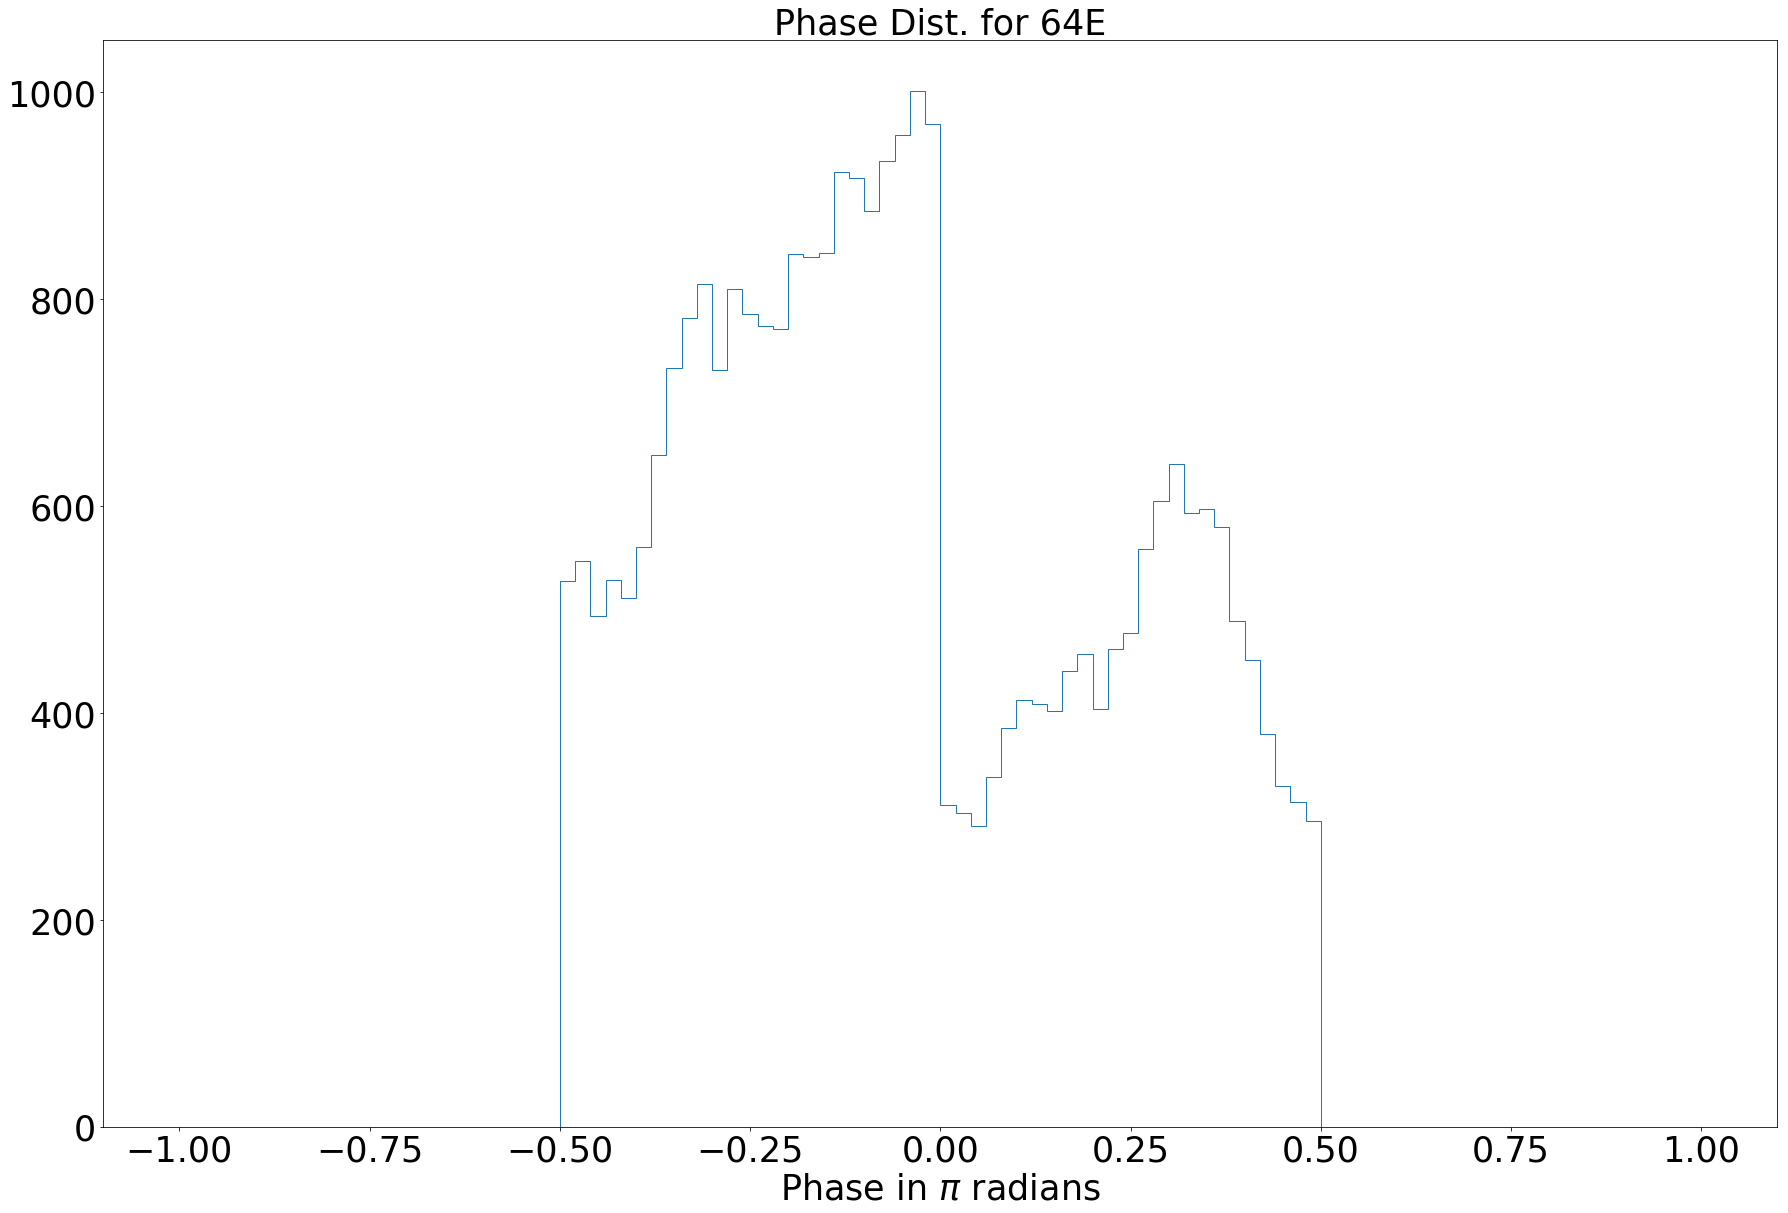

In [37]:
bd,ch=4,3
trutharray=pd.land(pars[:,-3]==bd,pars[:,-2]==ch)
plt.figure(figsize=(30,20))
phi=np.arctan(pars[:,1]/pars[:,0])
phi[pd.land(pars[:,0]<0,pars[:,1]<0)]*=-1
plt.hist(phi[trutharray]/np.pi,\
         bins=100,range=[-1,1],histtype='step')
plt.tick_params(labelsize=fs)
plt.title('Phase Dist. for '+pd.pixel(bd,ch),fontsize=fs)
plt.xlabel(r'Phase in $\pi$ radians',fontsize=fs)
plt.savefig('curve_fit_phase-'+pd.pixel(bd,ch)+'.pdf',fmt='pdf')
plt.show()

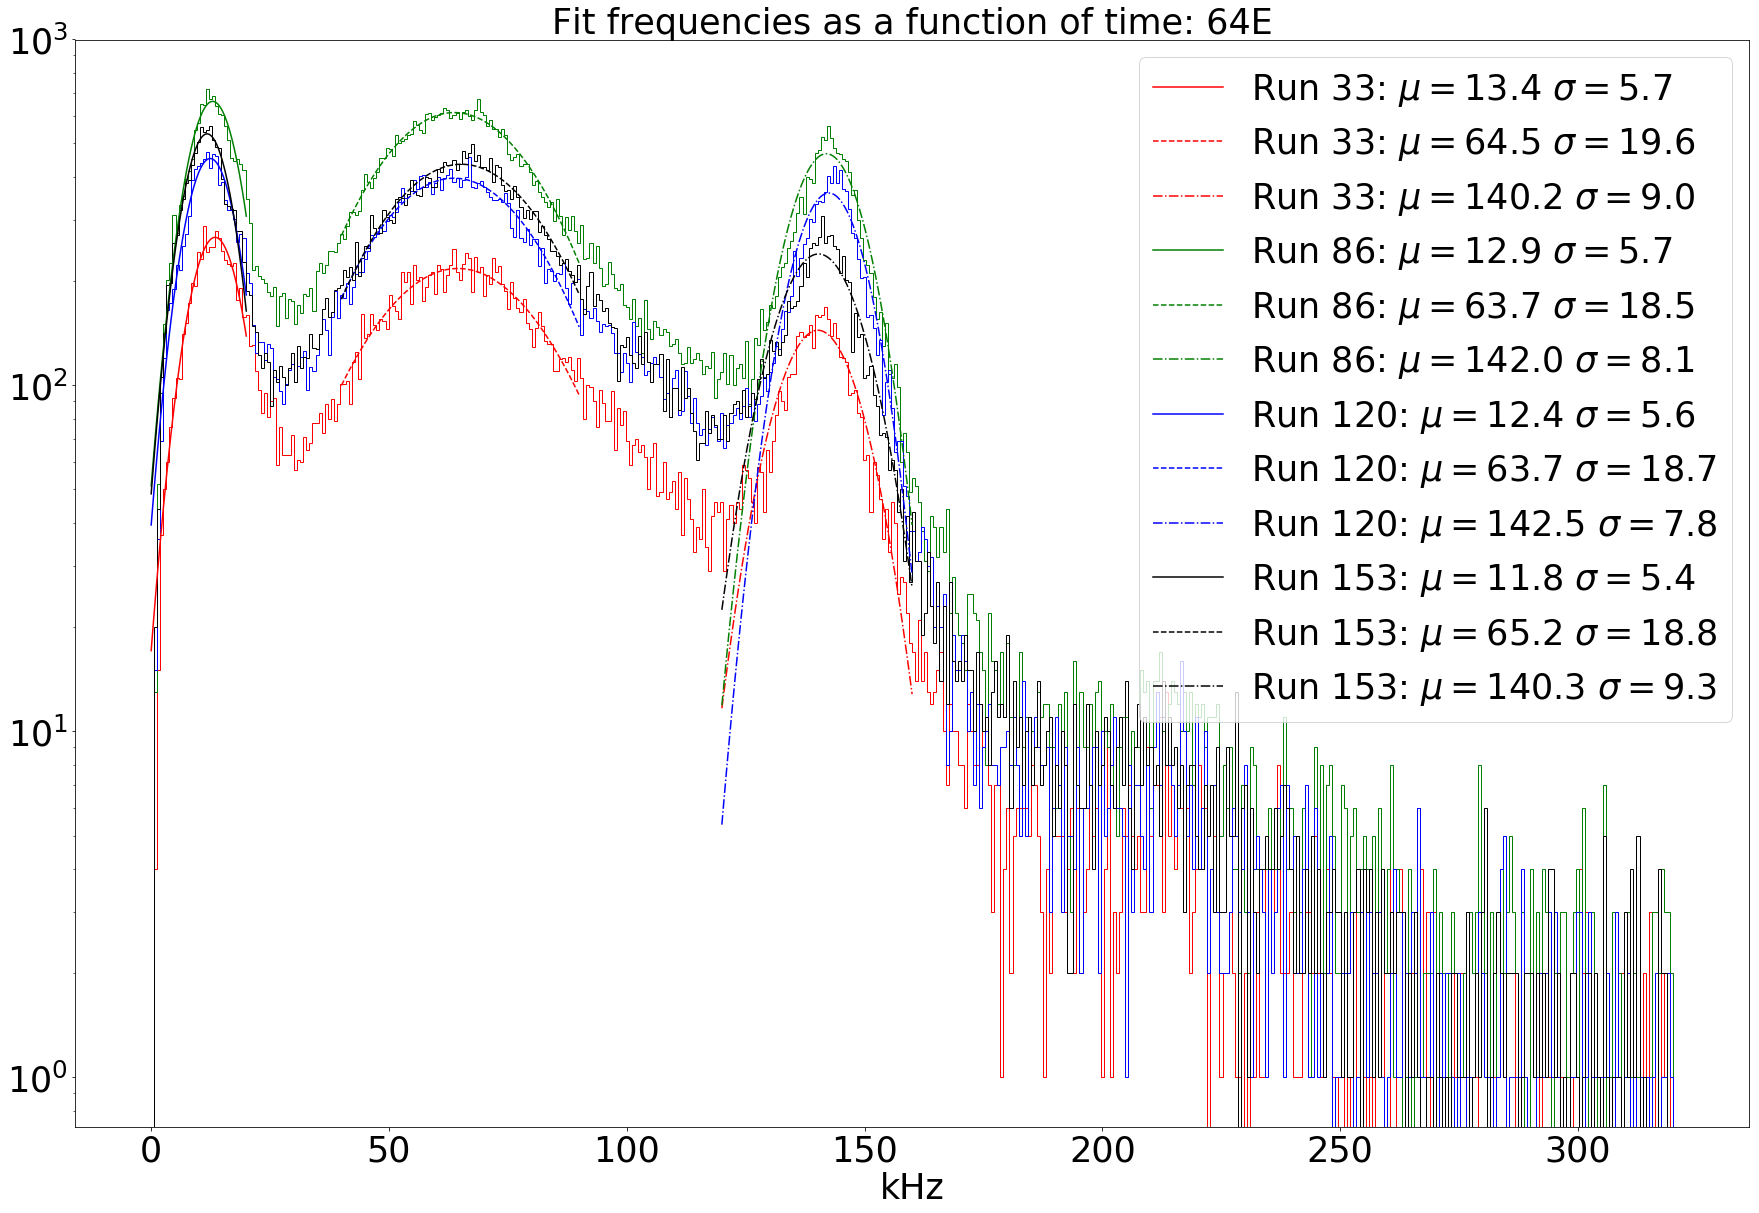

In [12]:
fs=35
bd,ch=4,3

data=[]
runs=['33','86','120','153']
for i in runs:
    name='/home/noah/Desktop/large_analysis/ca_analysis/oscillation/'+\
        'True_fit_pars/True-Fit-pars_Run_'+i+'-full.npy'
    data.append(np.load(name))

plt.figure(figsize=(30,20))

i=0
colors=['r','g','b','k']
for pars in data:
    trutharray=np.logical_and(pars[:,-3]==bd,pars[:,-2]==ch)
    hist,bins,patches=plt.hist(pars[:,3][trutharray]/(2*np.pi*4E-9)/1000,\
             bins=500,range=[0,320],histtype='step',color=colors[i])
    bins=pd.cbins(bins)
    beg,end=0,20
    t=np.linspace(beg,end,100)
    trutharray=pd.land(bins>beg,bins<end)
    fitbins,fithist=bins[trutharray],hist[trutharray]
    p,v=curve_fit(gauss,fitbins,fithist,p0=[max(fithist),beg+(end-beg)/2,10])
    plt.plot(t,gauss(t,*p),c=colors[i],label='Run '+runs[i]+\
             r': $\mu =${0:0.1f} $\sigma =${1:0.1f}'.format(p[1],p[2]))
    beg,end=40,90
    t=np.linspace(beg,end,100)
    trutharray=pd.land(bins>beg,bins<end)
    fitbins,fithist=bins[trutharray],hist[trutharray]
    p,v=curve_fit(gauss,fitbins,fithist,p0=[max(fithist),beg+(end-beg)/2,10])
    plt.plot(t,gauss(t,*p),c=colors[i],ls='--',label='Run '+runs[i]+\
             r': $\mu =${0:0.1f} $\sigma =${1:0.1f}'.format(p[1],p[2]))
    
    beg,end=120,160
    t=np.linspace(beg,end,100)
    trutharray=pd.land(bins>beg,bins<end)
    fitbins,fithist=bins[trutharray],hist[trutharray]
    p,v=curve_fit(gauss,fitbins,fithist,p0=[max(fithist),beg+(end-beg)/2,10])
    plt.plot(t,gauss(t,*p),c=colors[i],ls='-.',label='Run '+runs[i]+\
             r': $\mu =${0:0.1f} $\sigma =${1:0.1f}'.format(p[1],p[2]))
    i+=1
        
#plt.plot((130,130),(1,1e3),'k-')
plt.xlabel('kHz',fontsize=fs)
plt.yscale('log')
#plt.hist(pars[trutharray][:,4],bins=1000,range=[-100,100],histtype='step')
#plt.hist(pars[:,-2]*8+pars[:,-1],bins=48,range=[0,47])
plt.xlim()
plt.legend(fontsize=fs)
plt.tick_params(labelsize=fs)
plt.title('Fit frequencies as a function of time: '+pd.pixel(bd,ch),fontsize=fs)
plt.show()

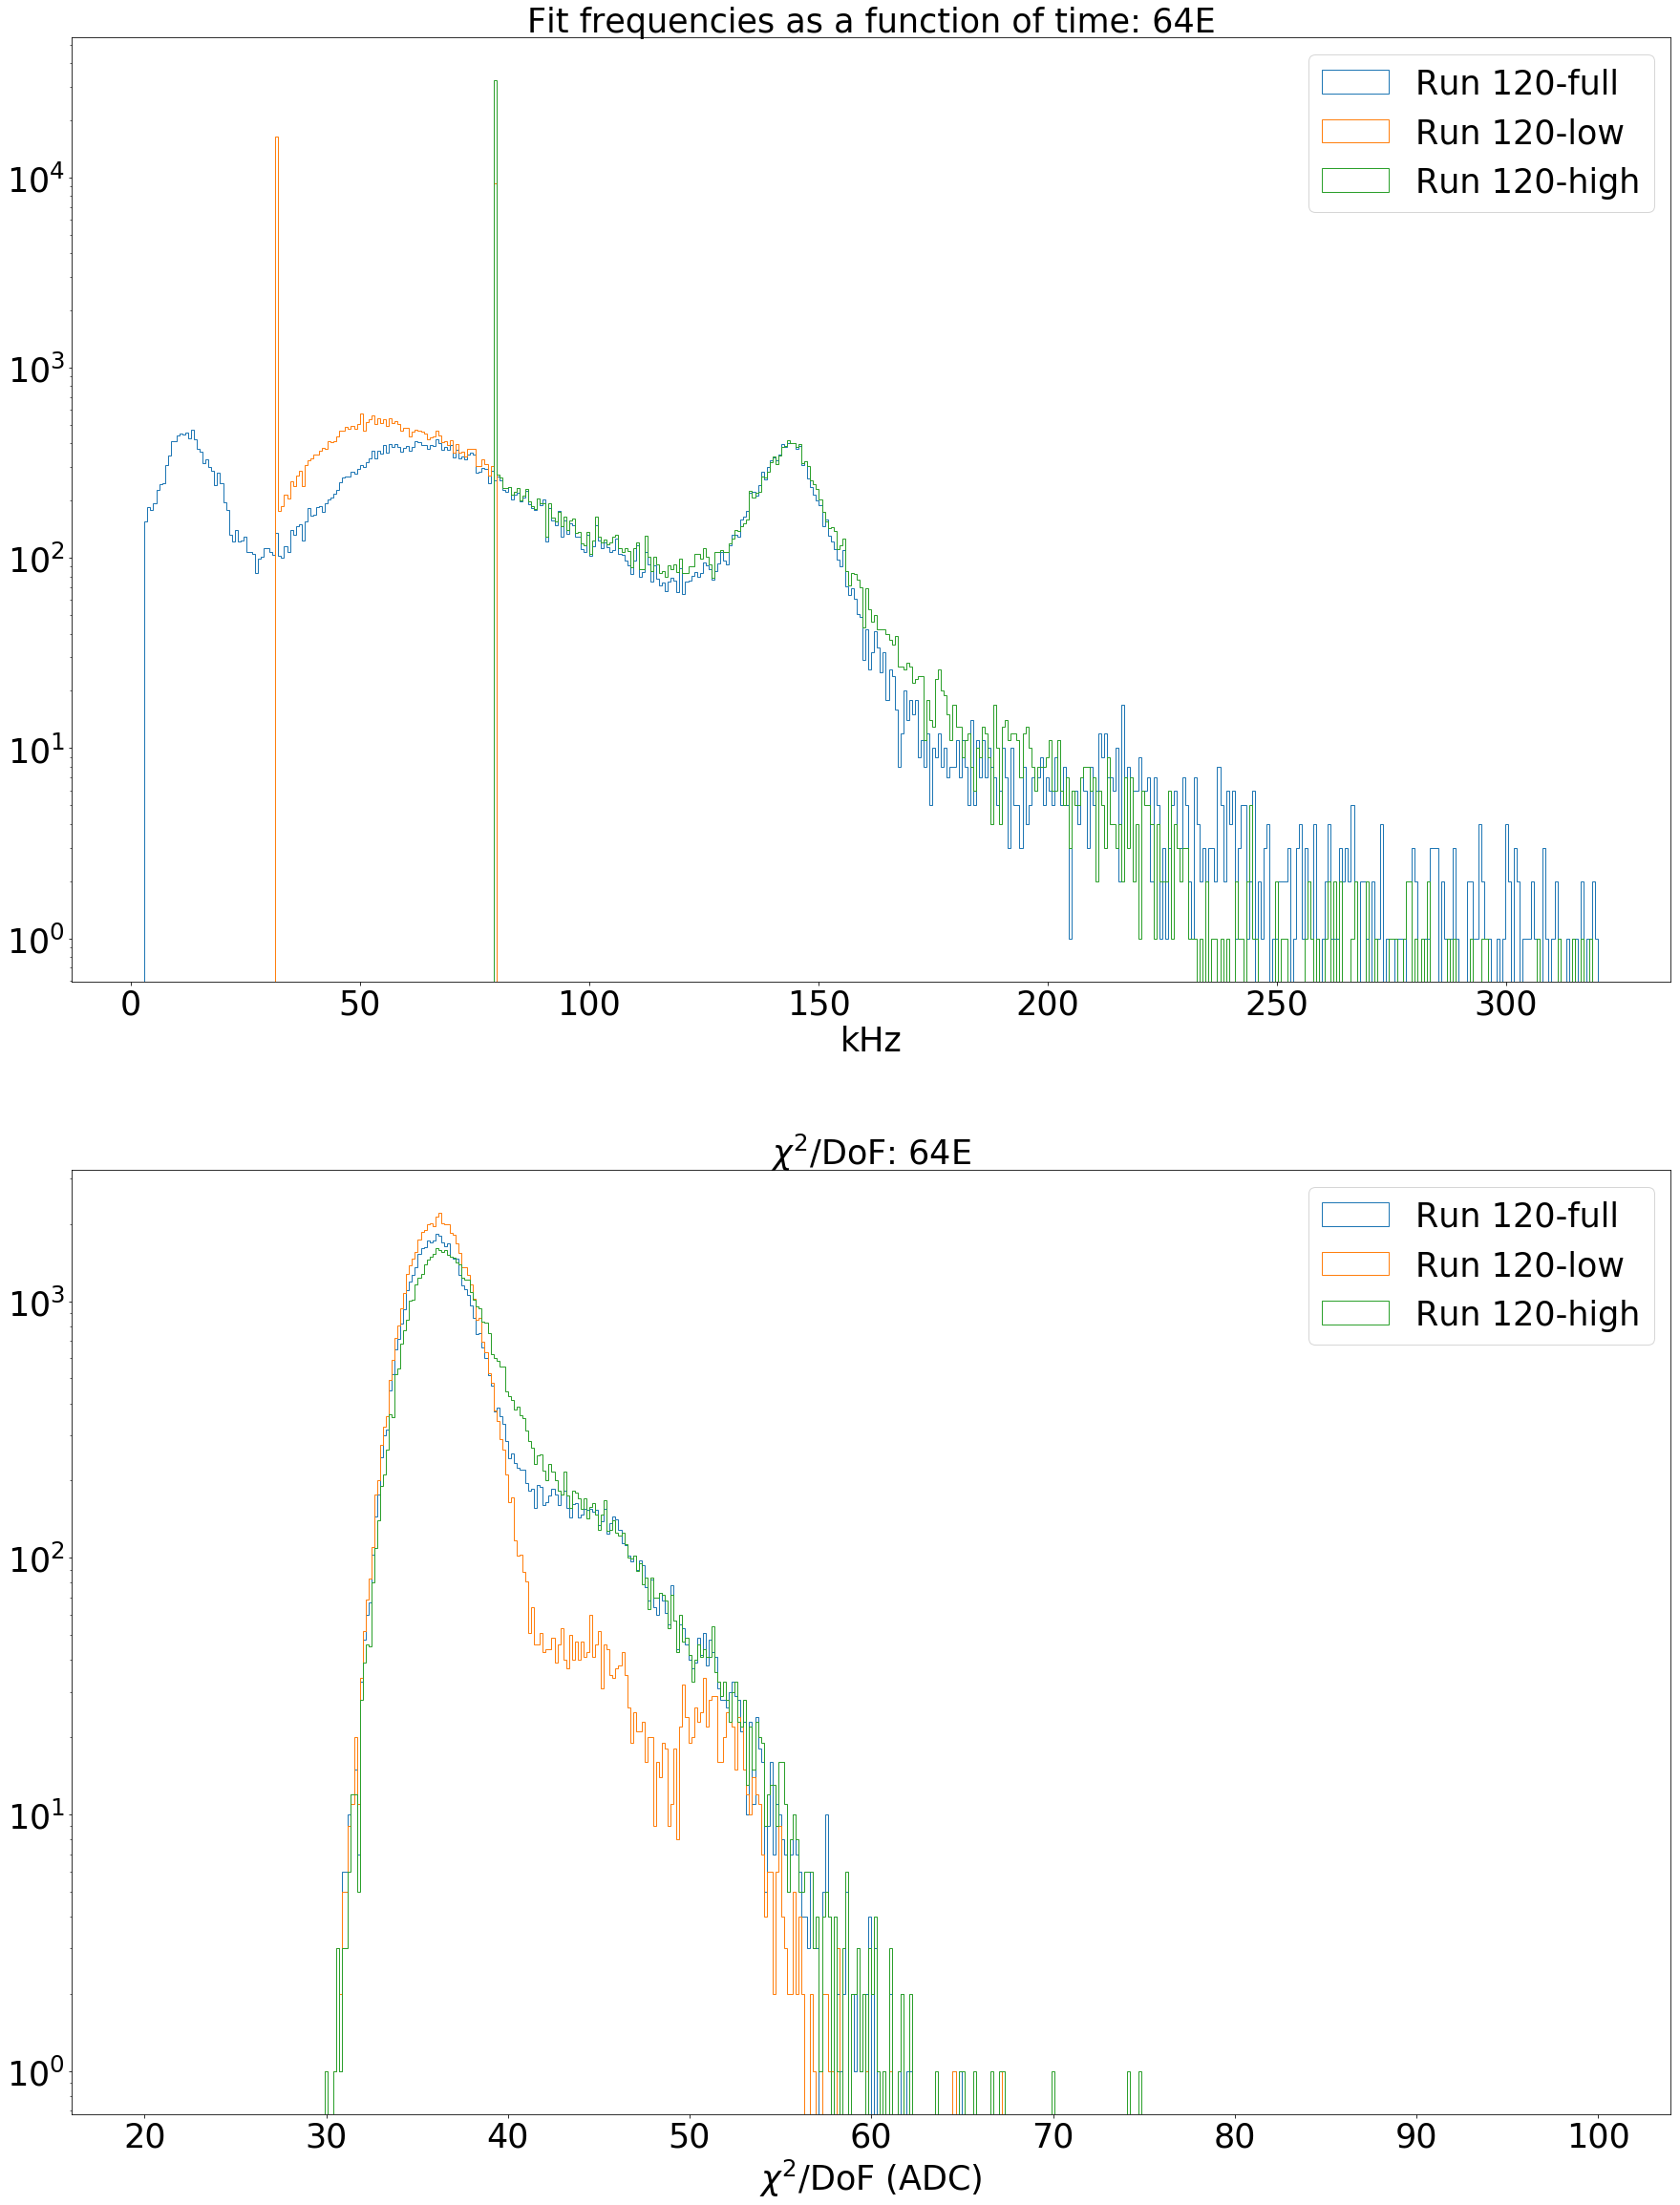

In [3]:
fs=35
bd,ch=4,3

data=[]
runs=['120-full','120-low','120-high']#,'120_low']
for i in runs:
    name='/home/noah/Desktop/large_analysis/ca_analysis/oscillation/True_fit_pars/'+\
            'True-Fit-pars_Run_'+i+'.npy'
    data.append(np.load(name))

fig,(ax1,ax2)=plt.subplots(2, 1,figsize=(30,40))

i=0
for pars in data:
    trutharray=np.logical_and(pars[:,-3]==bd,pars[:,-2]==ch)
    ax1.hist(pars[:,3][trutharray]/(2*np.pi*4E-9)/1000,\
             bins=500,range=[3,320],histtype='step',label='Run '+runs[i])
    ax2.hist(np.sqrt(pars[:,-4][trutharray]),bins=500,range=[20,100],histtype='step',label='Run '+runs[i])
    i+=1

ax1.set_xlabel('kHz',fontsize=fs)
ax1.set_yscale('log')
#plt.hist(pars[trutharray][:,4],bins=1000,range=[-100,100],histtype='step')
#plt.hist(pars[:,-2]*8+pars[:,-1],bins=48,range=[0,47])
ax1.legend(fontsize=fs)
ax1.tick_params(labelsize=fs)
ax1.set_title('Fit frequencies as a function of time: '+pd.pixel(bd,ch),fontsize=fs)


ax2.set_title(r'$\chi^2$/DoF: '+pd.pixel(bd,ch),fontsize=fs)
ax2.tick_params(labelsize=fs)
ax2.set_xlabel(r'$\chi^2$/DoF (ADC)', fontsize=fs)
ax2.set_yscale('log')
ax2.legend(fontsize=fs)
plt.savefig('range_comp')
plt.show()

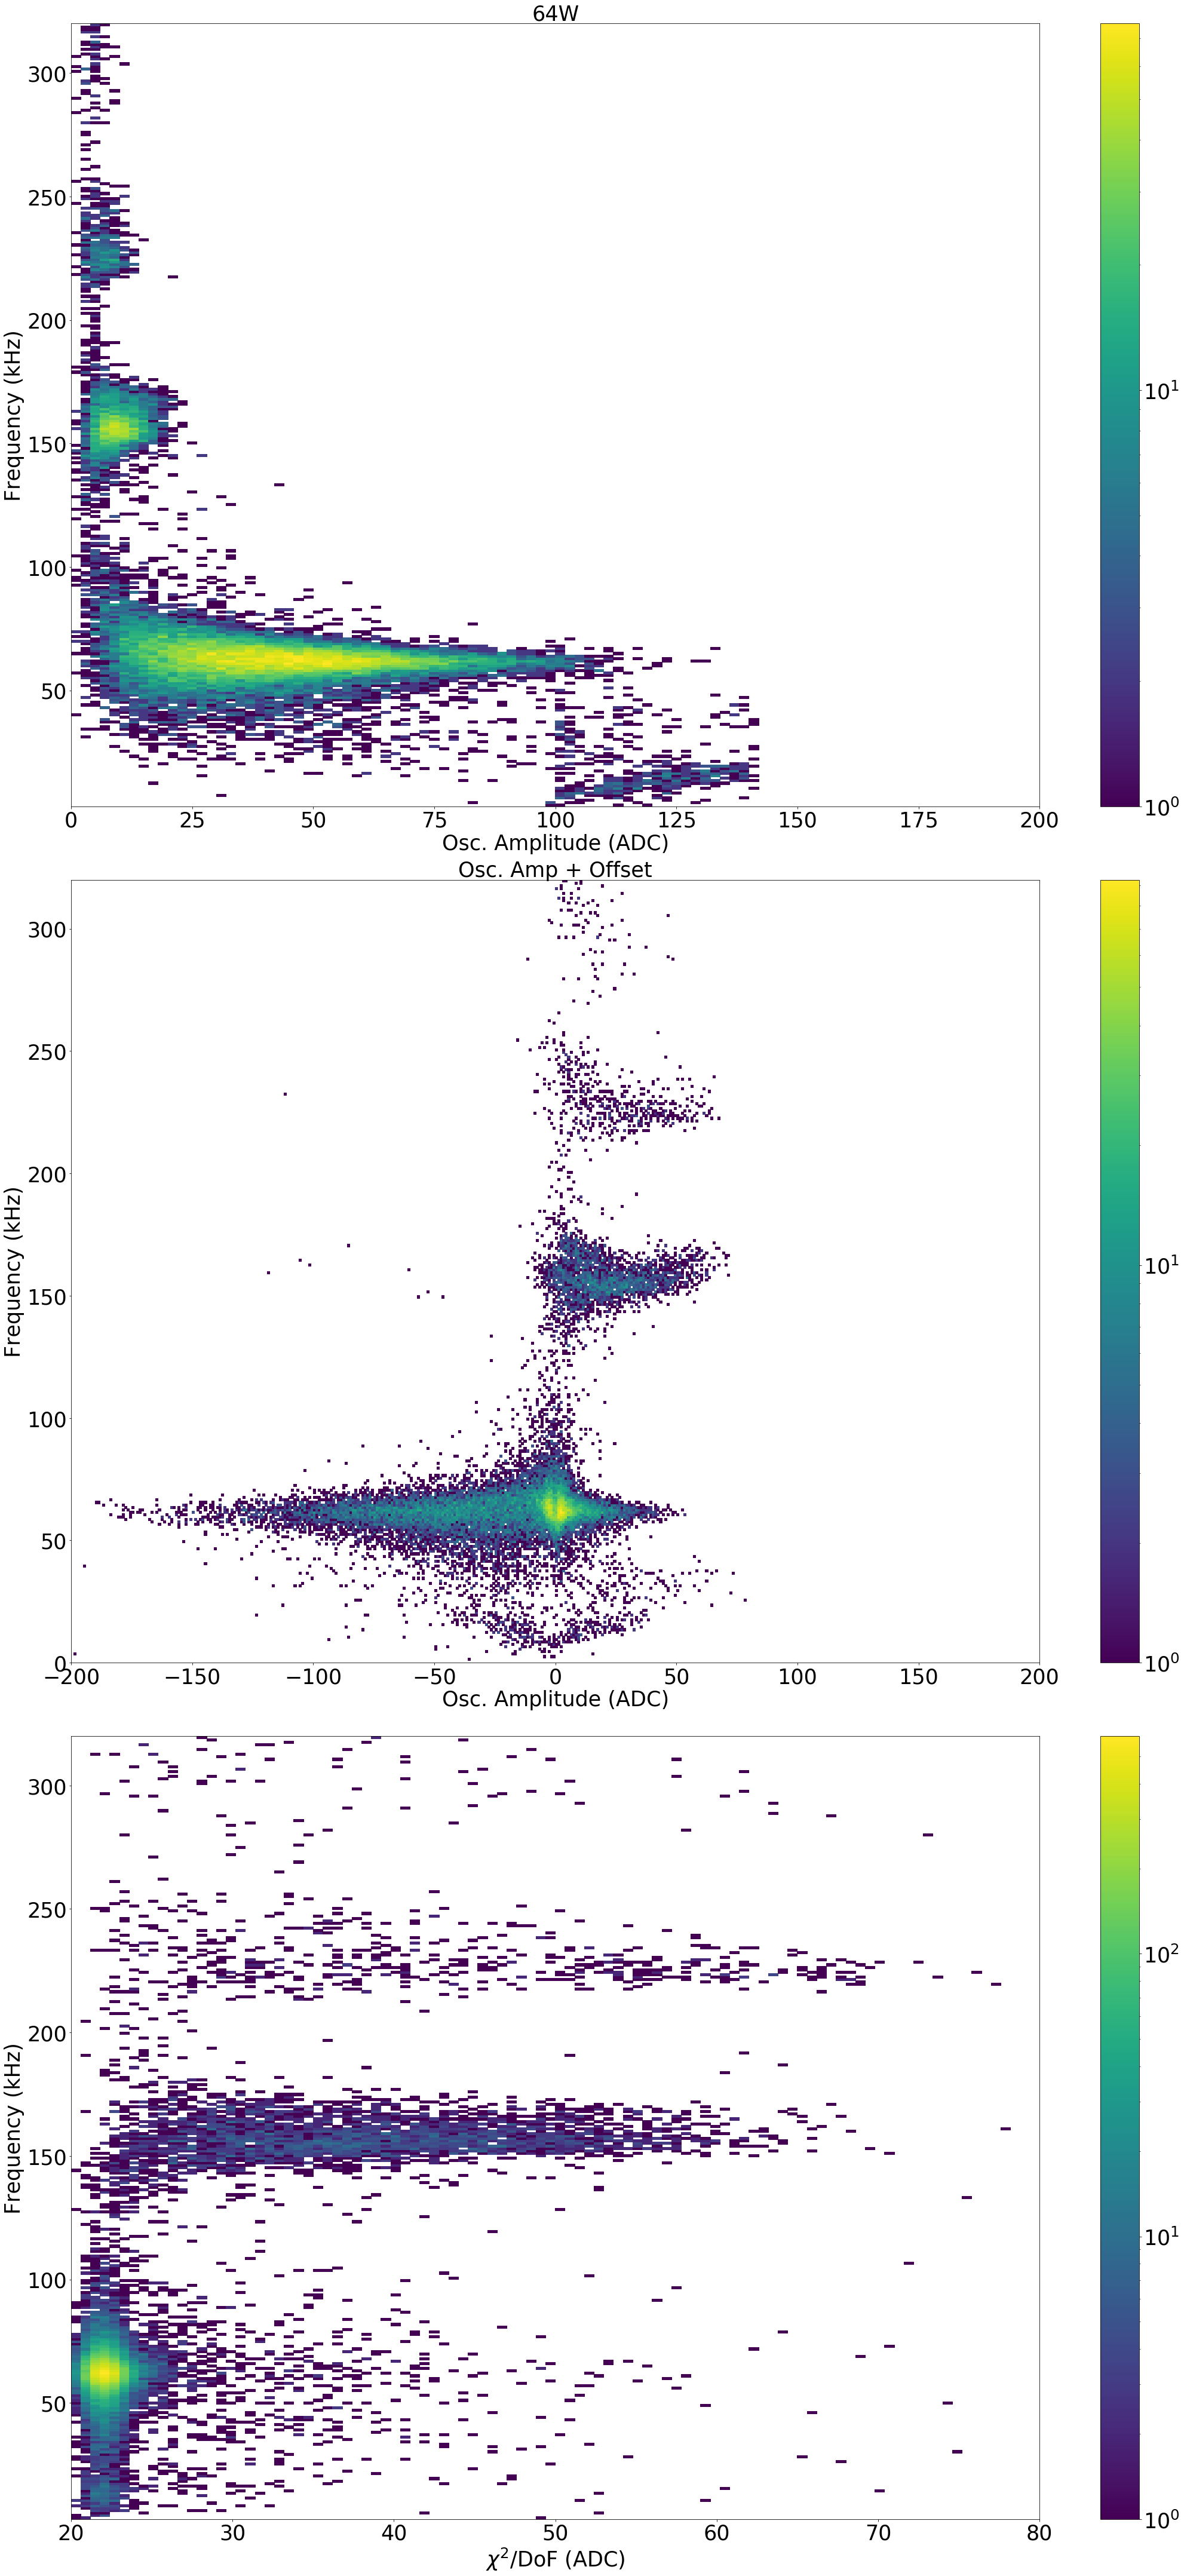

In [39]:
bd,ch=1,3
fs=35
pars=np.load('/home/noah/Desktop/large_analysis/ca_analysis/oscillation/True_fit_pars/'+\
             'True-Fit-pars_Run_33-full.npy')

fig,(ax1,ax3,ax2)=plt.subplots(3, 1,figsize=(30,60))

trutharray=np.logical_and(pars[:,-3]==bd,pars[:,-2]==ch)
im=ax1.hist2d(np.sqrt(pars[:,0][trutharray]**2.+pars[:,1][trutharray]**2.),\
           pars[:,3][trutharray]/(2*np.pi*4E-9)/1000,\
         bins=[100,320],range=([0,200],[3,320]),norm=mpl.colors.LogNorm())
cbar = plt.colorbar(im[3],ax=ax1)
cbar.ax.tick_params(labelsize=fs)
ax1.tick_params(labelsize=fs)
ax1.set_ylabel('Frequency (kHz)',fontsize=fs)
ax1.set_xlabel('Osc. Amplitude (ADC)',fontsize=fs)
ax1.set_title(pd.pixel(bd,ch),fontsize=fs)

im=ax2.hist2d(np.sqrt(pars[:,-4][trutharray]),pars[:,3][trutharray]/(2*np.pi*4E-9)/1000,\
         bins=[100,320],range=([20,80],[3,320]),norm=mpl.colors.LogNorm())
cbar = plt.colorbar(im[3],ax=ax2)
cbar.ax.tick_params(labelsize=fs)
ax2.tick_params(labelsize=fs)
ax2.set_xlabel(r'$\chi^2$/DoF (ADC)',fontsize=fs)
ax2.set_ylabel(r'Frequency (kHz)',fontsize=fs)


phi=np.arctan(pars[:,1]/pars[:,0])
phi[pd.land(pars[:,0]<0,pars[:,1]<0)]*=-1
factor=np.ones_like(phi)
factor[phi<0]=-1
factor=factor[trutharray]
im=ax3.hist2d(factor*np.sqrt(pars[:,0][trutharray]**2.+pars[:,1][trutharray]**2.)+pars[:,2][trutharray],\
           pars[:,3][trutharray]/(2*np.pi*4E-9)/1000,\
         bins=[400,320],range=([-200,200],[0,320]),norm=mpl.colors.LogNorm())
cbar = plt.colorbar(im[3],ax=ax3)
cbar.ax.tick_params(labelsize=fs)
ax3.tick_params(labelsize=fs)
ax3.set_ylabel('Frequency (kHz)',fontsize=fs)
ax3.set_xlabel('Osc. Amplitude (ADC)',fontsize=fs)
ax3.set_title('Osc. Amp + Offset',fontsize=fs)

fig.tight_layout()
plt.savefig(pd.pixel(bd,ch)+'-2d_histos')
plt.show()

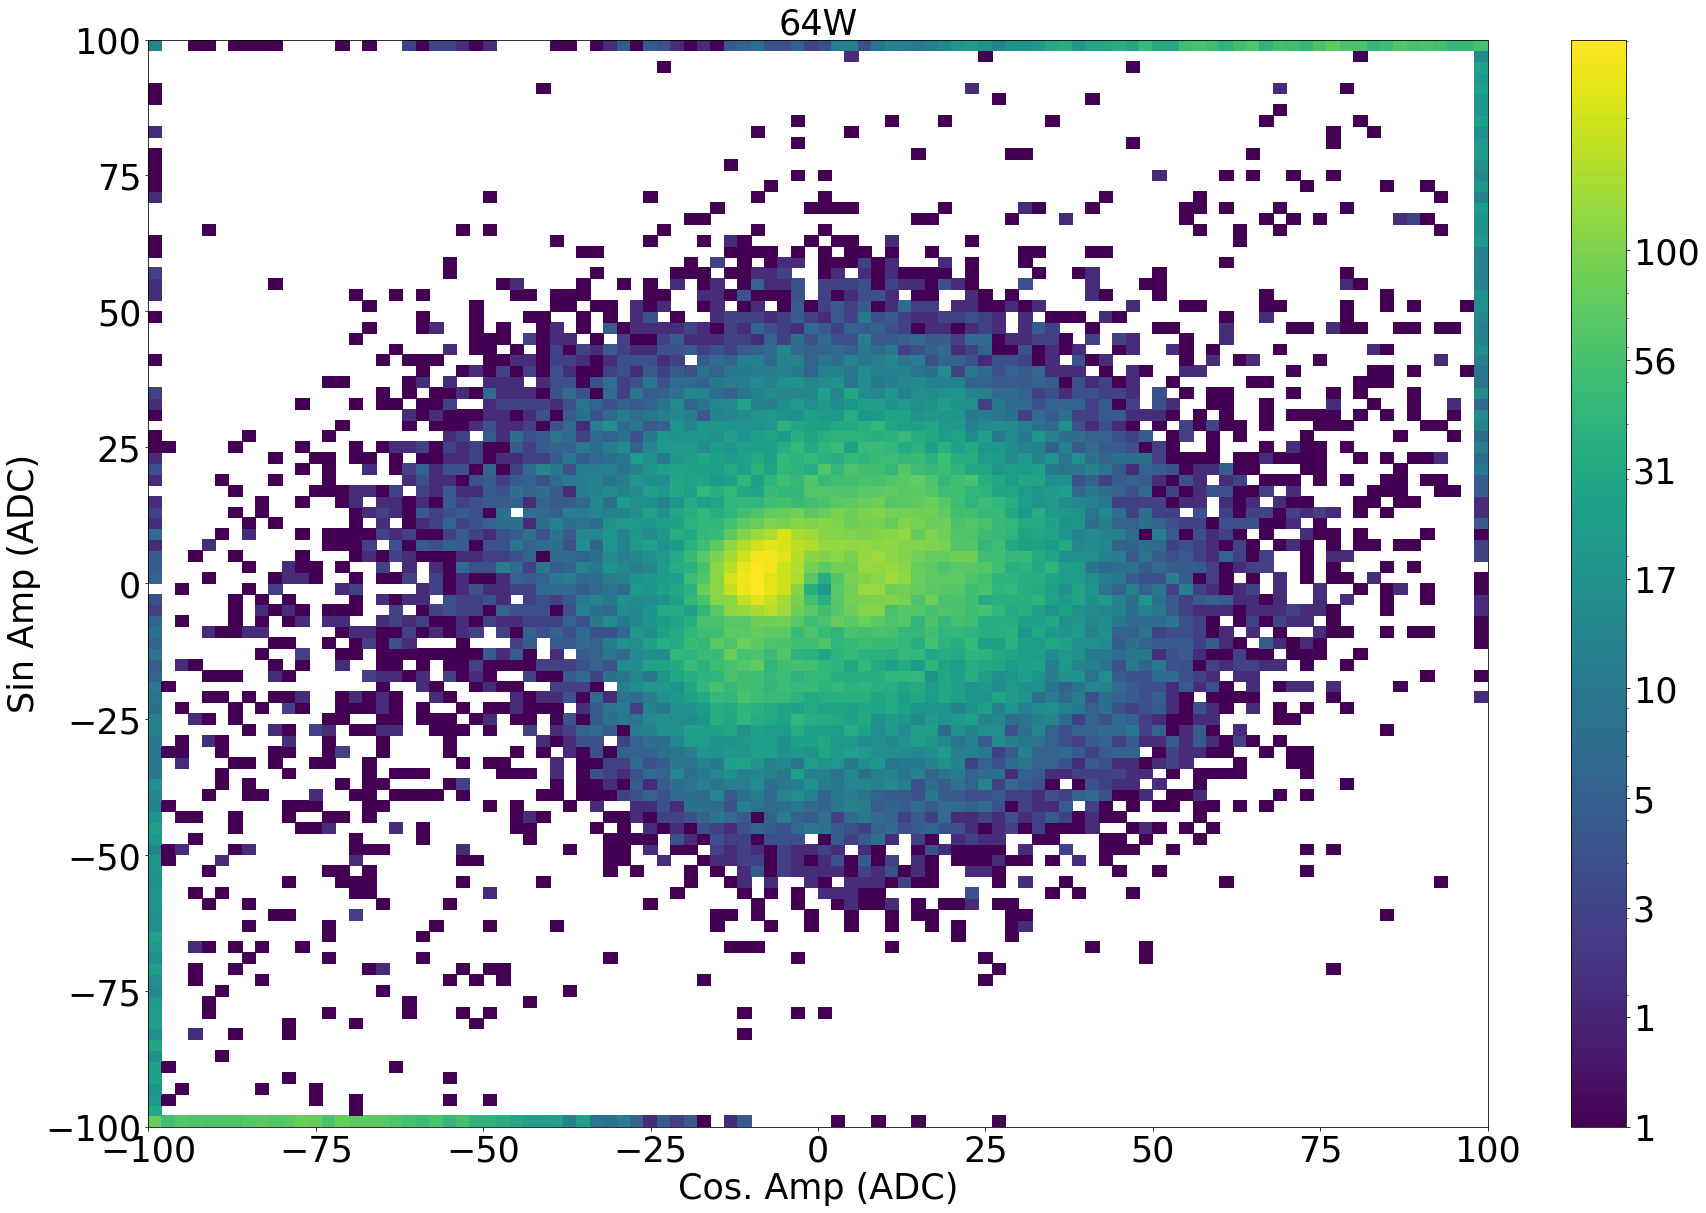

In [56]:
bd,ch=1,3
fs=35
pars=np.load('/home/noah/Desktop/large_analysis/ca_analysis/oscillation/True_fit_pars/'+\
             'True-Fit-pars_Run_33-full.npy')

fig,(ax1,ax3,ax2)=plt.subplots(3, 1,figsize=(30,60))

trutharray=np.logical_and(pars[:,-3]==bd,pars[:,-2]==ch)
im=ax1.hist2d(np.sqrt(pars[:,0][trutharray]**2.+pars[:,1][trutharray]**2.),\
           pars[:,3][trutharray]/(2*np.pi*4E-9)/1000,\
         bins=[100,320],range=([0,200],[3,320]),norm=mpl.colors.LogNorm())
cbar = plt.colorbar(im[3],ax=ax1)
cbar.ax.tick_params(labelsize=fs)
ax1.tick_params(labelsize=fs)
ax1.set_ylabel('Frequency (kHz)',fontsize=fs)
ax1.set_xlabel('Osc. Amplitude (ADC)',fontsize=fs)
ax1.set_title(pd.pixel(bd,ch),fontsize=fs)

im=ax2.hist2d(np.sqrt(pars[:,-4][trutharray]),pars[:,3][trutharray]/(2*np.pi*4E-9)/1000,\
         bins=[100,320],range=([20,80],[3,320]),norm=mpl.colors.LogNorm())
cbar = plt.colorbar(im[3],ax=ax2)
cbar.ax.tick_params(labelsize=fs)
ax2.tick_params(labelsize=fs)
ax2.set_xlabel(r'$\chi^2$/DoF (ADC)',fontsize=fs)
ax2.set_ylabel(r'Frequency (kHz)',fontsize=fs)


amp=pars[:,0][trutharray]*np.cos(np.arctan(pars[:,1][trutharray]/pars[:,0][trutharray]))
im=ax3.hist2d(np.sqrt(pars[:,0][trutharray]**2.+pars[:,1][trutharray]**2.)-np.abs(pars[:,2][trutharray]),\
           pars[:,3][trutharray]/(2*np.pi*4E-9)/1000,\
         bins=[200,320],range=([-100,100],[3,320]),norm=mpl.colors.LogNorm())
cbar = plt.colorbar(im[3],ax=ax3)
cbar.ax.tick_params(labelsize=fs)
ax3.tick_params(labelsize=fs)
ax3.set_ylabel('Frequency (kHz)',fontsize=fs)
ax3.set_xlabel('Osc. Amplitude (ADC)',fontsize=fs)
ax3.set_title('Osc. Amp - |Offset|',fontsize=fs)

fig.tight_layout()
plt.show()

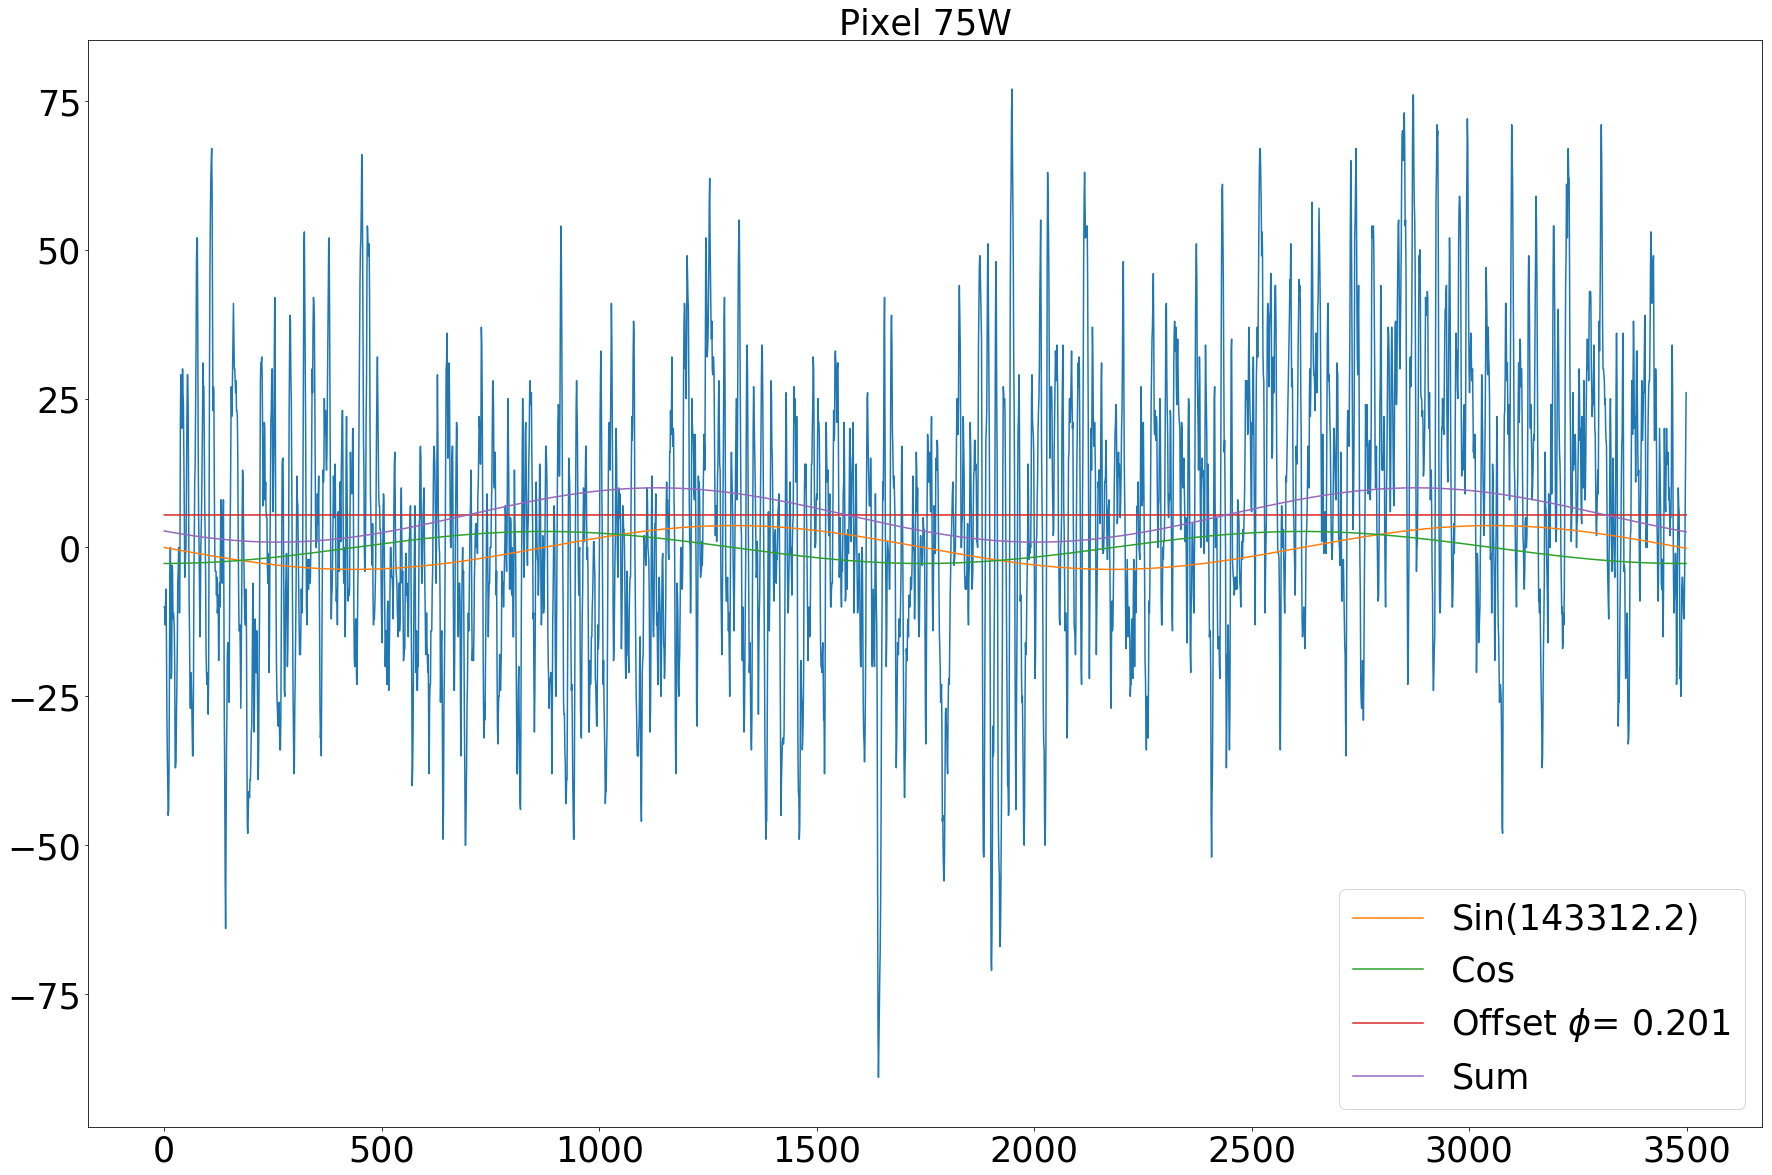

In [53]:
bd,ch=1,3
fs=35
t=np.arange(3500)
pars=np.load('/home/noah/Desktop/large_analysis/ca_analysis/oscillation/True_fit_pars/'+\
             'True-Fit-pars_Run_120-full.npy')
data=fr.raw('/home/noah/Desktop/large_analysis/ca_analysis/Run_120_0.bin',length=3500,row=0,numwaves=10000)
wo.baseline_restore(data,600)
plt.figure(figsize=(30,20))
count=0
w=2*np.pi*140e3*4e-9
for i in range(len(pars)):
    bd,ch=pars[]
    #if pars[i,0] > 90 or pars[i,1]>90:
    if pars[i,3]>w:# and np.sqrt(pars[i,0]**2+pars[i,1]**2)+pars[i,2] > 200:
        count +=1
        if count == 3:
            plt.plot(t,data['wave'][int(pars[i,-1])])
            plt.plot(t,pars[i,0]*np.sin(pars[i,3]*t),label='Sin({:0.1f})'.format(pars[i,3]/(2*np.pi*4E-9)))
            plt.plot(t,pars[i,1]*np.cos(pars[i,3]*t),label='Cos')
            plt.plot(t,pars[i,2]*np.ones(3500),\
                     label=r'Offset $\phi$= ''{:0.3f}'.format(np.arctan(pars[i,1]/pars[i,0])/np.pi))
            plt.plot(t,pars[i,0]*np.sin(pars[i,3]*t)+\
                    pars[i,1]*np.cos(pars[i,3]*t)+ \
                    pars[i,2]*np.ones(3500),label='Sum')
            plt.title('Pixel '+pd.pixel(data['board'][int(pars[i,-1])],data['channel'][int(pars[i,-1])]),\
                      fontsize=fs)
            break
plt.tick_params(labelsize=fs)
plt.legend(fontsize=fs,loc=4)
plt.show()